In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from IPython.display import display
from abc import ABC, abstractmethod
from scipy.spatial import cKDTree # Para otimização do 1-NN
from typing import Dict, List, Tuple, Any

# Métodos

In [18]:
class BaseClassifier(ABC):
    """
    Classe base abstrata para classificadores.
    
    Implementa um harness de avaliação completo, incluindo a divisão de dados,
    múltiplas execuções (rodadas) e cálculo de estatísticas de desempenho.
    Classes filhas precisam apenas implementar os métodos _train e _predict.
    """
    def __init__(self):
        self.X_train = None
        self.y_train = None
        # Atributos específicos do modelo podem ser definidos em _train
        self.model_params = {}

    @abstractmethod
    def _train(self, X_train: np.ndarray, y_train: np.ndarray) -> None:
        """
        Treina o classificador. Deve ser implementado pela classe filha.
        
        Parâmetros:
        - X_train: Amostras de treino (features).
        - y_train: Rótulos de treino.
        """
        pass

    @abstractmethod
    def _predict(self, X_test: np.ndarray) -> np.ndarray:
        """
        Prevê os rótulos para as amostras de teste. Deve ser implementado pela classe filha.

        Parâmetros:
        - X_test: Amostras de teste (features).

        Retorna:
        - Array com os rótulos previstos.
        """
        pass

    def evaluate(self, data: np.ndarray, num_runs: int, train_percent: float) -> Tuple[np.ndarray, np.ndarray, Dict[str, Any]]:
        """
        Executa a avaliação completa do classificador.

        Parâmetros:
        - data: Array numpy completo com features e o rótulo na última coluna.
        - num_runs: Número de execuções (rodadas) para a avaliação.
        - train_percent: Percentual de dados a serem usados para treinamento.

        Retorna:
        - STATS: Estatísticas de acurácia (média, min, max, mediana, desvio padrão).
        - TX_OK: Vetor com a taxa de acerto de cada uma das execuções.
        - last_run_info: Dicionário contendo informações da última execução (modelo, dados, etc).
        """
        n_total_samples, p_plus_1 = data.shape
        X_data = data[:, :-1]
        y_data = data[:, -1].astype(int)

        n_train = round(train_percent * n_total_samples / 100)
        n_test = n_total_samples - n_train
        
        accuracy_rates = np.zeros(num_runs)
        
        print(f"Executando {self.__class__.__name__}...")

        for r in range(num_runs):
            permutation = np.random.permutation(n_total_samples)
            train_indices = permutation[:n_train]
            test_indices = permutation[n_train:]

            self.X_train, self.y_train = X_data[train_indices], y_data[train_indices]
            X_test, y_test = X_data[test_indices], y_data[test_indices]
            
            # Garante que todas as classes estão presentes no treino para evitar erros
            if len(np.unique(self.y_train)) != len(np.unique(y_data)):
                # Em um caso real, poderíamos forçar a estratificação ou pular a rodada
                continue

            self._train(self.X_train, self.y_train)
            predicted_labels = self._predict(X_test)

            correct = np.sum(predicted_labels == y_test)
            accuracy_rates[r] = 100 * correct / n_test

        stats = np.array([
            np.mean(accuracy_rates), np.min(accuracy_rates), np.max(accuracy_rates),
            np.median(accuracy_rates), np.std(accuracy_rates)
        ])
        
        last_run_info = {
            "model_params": self.model_params,
            "X_train": self.X_train,
            "y_train": self.y_train
        }

        print(f"Finalizado: {self.__class__.__name__}. Acurácia Média: {stats[0]:.2f}%")
        return stats, accuracy_rates, last_run_info

In [ ]:
# --- 1. Distância Mínima do Centroide (DMC) ---
class DMC(BaseClassifier):
    def _train(self, X_train: np.ndarray, y_train: np.ndarray):
        self.model_params['centroids'] = {}
        self.model_params['class_labels'] = np.unique(y_train)
        for k in self.model_params['class_labels']:
            self.model_params['centroids'][k] = np.mean(X_train[y_train == k], axis=0)

    def _predict(self, X_test: np.ndarray) -> np.ndarray:
        centroids = self.model_params['centroids']
        class_labels = self.model_params['class_labels']
        distances = np.zeros((X_test.shape[0], len(class_labels)))
        
        for i, k in enumerate(class_labels):
            distances[:, i] = np.linalg.norm(X_test - centroids[k], axis=1)
            
        predicted_indices = np.argmin(distances, axis=1)
        return class_labels[predicted_indices]

# --- 2. 1-Vizinho Mais Próximo (1-NN) - Otimizado ---
class NN1(BaseClassifier):
    def _train(self, X_train: np.ndarray, y_train: np.ndarray):
        # Para o 1-NN, o "treino" é apenas memorizar os dados e construir a árvore
        self.model_params['kdtree'] = cKDTree(X_train)
        self.model_params['y_train'] = y_train

    def _predict(self, X_test: np.ndarray) -> np.ndarray:
        # A busca na k-d tree é muito mais rápida que a busca linear
        _, nearest_indices = self.model_params['kdtree'].query(X_test, k=1)
        return self.model_params['y_train'][nearest_indices]

# --- 3. Máxima Correlação (MaxCorr) ---
class MaxCorr(BaseClassifier):
    def _train(self, X_train, y_train):
        self.model_params['norm_centroids'] = {}
        self.model_params['class_labels'] = np.unique(y_train)
        for k in self.model_params['class_labels']:
            centroid = np.mean(X_train[y_train == k], axis=0)
            norm = np.linalg.norm(centroid)
            self.model_params['norm_centroids'][k] = centroid / (norm + 1e-9)

    def _predict(self, X_test):
        norm_centroids = self.model_params['norm_centroids']
        class_labels = self.model_params['class_labels']
        
        norms_X_test = np.linalg.norm(X_test, axis=1, keepdims=True)
        X_test_norm = X_test / (norms_X_test + 1e-9)
        
        correlations = np.zeros((X_test.shape[0], len(class_labels)))
        
        for i, k in enumerate(class_labels):
            correlations[:, i] = X_test_norm @ norm_centroids[k]
        
        predicted_indices = np.argmax(correlations, axis=1)
        return class_labels[predicted_indices]

# --- 4. Classificador Quadrático (QDA) e suas Variantes ---
class QDA(BaseClassifier):
    def __init__(self, regularization_param=None, mode='QDA'):
        super().__init__()
        self.regularization_param = regularization_param
        self.mode = mode # 'QDA', 'Tikhonov', 'LDA', 'Friedman', 'NaiveBayes'
        
    def _train(self, X_train, y_train):
        num_features = X_train.shape[1]
        self.model_params['class_labels'] = np.unique(y_train)
        self.model_params['covs'] = {}
        self.model_params['means'] = {}
        self.model_params['inv_covs'] = {}
        self.model_params['log_dets'] = {}
        self.model_params['log_priors'] = {}

        # Lógica para variantes que precisam de uma matriz de covariância pooled
        pooled_cov = np.zeros((num_features, num_features))
        
        for k in self.model_params['class_labels']:
            X_k = X_train[y_train == k]
            n_k = X_k.shape[0]
            prior = n_k / len(y_train)
            
            self.model_params['means'][k] = np.mean(X_k, axis=0)
            self.model_params['log_priors'][k] = np.log(prior)
            
            cov_k = np.cov(X_k, rowvar=False)


            # Seleciona a matriz de covariância com base no modo
            if self.mode == 'Tikhonov':
                cov_k += np.eye(num_features) * self.regularization_param
            elif self.mode in ['LDA', 'Friedman']:
                pooled_cov += cov_k * prior
                if self.mode == 'Friedman':
                    self.model_params['covs'][k] = cov_k
            elif self.mode == 'NaiveBayes':
                cov_k = np.diag(np.diag(cov_k))

            sign, log_det = np.linalg.slogdet(cov_k)
            self.model_params['inv_covs'][k] = np.linalg.pinv(cov_k)
            self.model_params['log_dets'][k] = log_det if sign > 0 else -np.inf


        if self.mode == 'LDA':
            sign, log_det = np.linalg.slogdet(pooled_cov)
            for k in self.model_params['class_labels']:
                self.model_params['inv_covs'][k] = np.linalg.pinv(pooled_cov)
                self.model_params['log_dets'][k] = log_det if sign > 0 else -np.inf
        if self.mode == 'Friedman':
            for k in self.model_params['class_labels']:
                X_k = X_train[y_train == k]
                n_k = X_k.shape[0]
                c = self.model_params['covs'][k]
                lamba_parameter = self.regularization_param
                cov_k_numerator = (1-lamba_parameter)*(n_k*c) + lamba_parameter * (pooled_cov*len(X_train))
                cov_k_divisor = (1 - lamba_parameter)*n_k + lamba_parameter * len(X_train)

                cov_k = (1/cov_k_divisor)*cov_k_numerator

                sign, log_det = np.linalg.slogdet(cov_k)
                self.model_params['inv_covs'][k] = np.linalg.pinv(cov_k)
                self.model_params['log_dets'][k] = np.linalg.slogdet(cov_k)[1]

    def _predict(self, X_test):
        class_labels = self.model_params['class_labels']
        scores = np.zeros((X_test.shape[0], len(class_labels)))
        
        scores_debug = np.zeros((X_test.shape[0], len(class_labels)))

        for i, k in enumerate(class_labels):
            diff = X_test - self.model_params['means'][k]
            mahalanobis = np.sum((diff @ self.model_params['inv_covs'][k]) * diff, axis=1)
            # A função discriminante é -0.5 * (mahalanobis + log_det - 2*log_prior)
            # Usamos argmin, então podemos ignorar o -0.5 e minimizar o interior
            scores[:, i] = mahalanobis + self.model_params['log_dets'][k] - 2 * self.model_params['log_priors'][k]
            if self.mode == 'LDA':
                # Para LDA, não precisamos calcular a parte de log_prior
                scores[:, i] = mahalanobis - 2* self.model_params['log_dets'][k]
                scores_debug[:, i] = mahalanobis - 2 * self.model_params['log_dets'][k]
        if self.mode == 'LDA':
            (f"Scores Debug: {scores_debug-scores}")  # Debugging line to check scores
        predicted_indices = np.argmin(scores, axis=1)
        return class_labels[predicted_indices]

--- INICIANDO AVALIAÇÃO DOS CLASSIFICADORES ---
Executando QDA...
Finalizado: QDA. Acurácia Média: 9.09%
Executando QDA...
Finalizado: QDA. Acurácia Média: 78.18%
Executando QDA...
Finalizado: QDA. Acurácia Média: 75.15%
Executando QDA...
Finalizado: QDA. Acurácia Média: 87.88%
Executando QDA...
Finalizado: QDA. Acurácia Média: 7.88%
Executando MaxCorr...
Finalizado: MaxCorr. Acurácia Média: 81.21%
Executando DMC...
Finalizado: DMC. Acurácia Média: 78.18%
Executando NN1...
Finalizado: NN1. Acurácia Média: 75.76%
\n--- AVALIAÇÃO FINALIZADA ---\n
--- TABELA DE RESULTADOS ---


,Média (%),Mínimo (%),Máximo (%),Mediana (%),Desvio Padrão,Tempo (s)
QDA (Quadrático),9.09,0.00,12.12,12.12,4.69,3.79
Variante 1 (Tikhonov λ=0.01),78.18,66.67,84.85,78.79,6.75,2.92
Variante 2,75.15,9.09,93.94,93.94,33.22,5.64
Variante 3 (Friedman λ=0.5),87.88,81.82,90.91,87.88,3.32,4.60
Variante 4 (Naive Bayes),7.88,3.03,12.12,9.09,3.09,3.81
MaxCorr,81.21,75.76,93.94,78.79,6.75,0.00
DMC,78.18,63.64,87.88,81.82,8.87,0.01
1-NN,75.76,66.67,81.82,75.76,5.07,0.01


/tmp/ipykernel_12709/4221865595.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(all_tx_ok, patch_artist=True, labels=classifier_names)
/tmp/ipykernel_12709/4221865595.py:68: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', len(all_tx_ok))


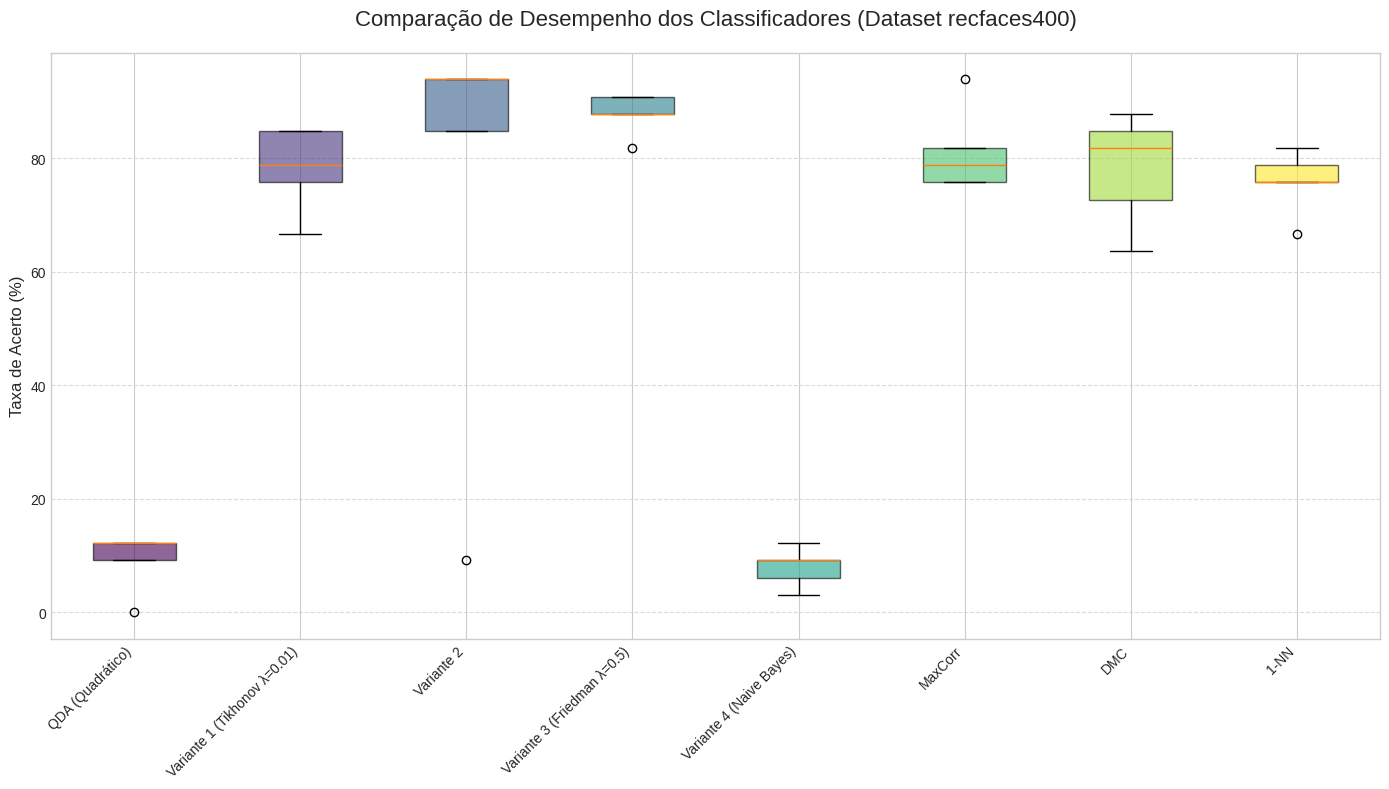

In [20]:
# --- Carregamento dos dados ---
try:
    D = np.loadtxt('recfaces400.dat')
except FileNotFoundError:
    print("Erro: Arquivo 'recfaces400.dat' não encontrado. Usando dados aleatórios para demonstração.")
    D = np.random.rand(600, 401)
    D[:, -1] = np.random.randint(1, 16, 600)

# --- Parâmetros ---
Nr = 5      # Número de rodadas
Ptrain = 80  # Percentual de treino

# --- Definição dos Classificadores ---
# A ordem aqui define a ordem na tabela e no gráfico
classifiers = {
    "QDA (Quadrático)": QDA(mode='QDA'),
    "Variante 1 (Tikhonov λ=0.01)": QDA(mode='Tikhonov', regularization_param=0.01),
    "Variante 2": QDA(mode='LDA'),
    "Variante 3 (Friedman λ=0.5)": QDA(mode='Friedman', regularization_param=0.5),
    "Variante 4 (Naive Bayes)": QDA(mode='NaiveBayes'),
    "MaxCorr": MaxCorr(),
    "DMC": DMC(),
    "1-NN": NN1()
}

# --- Execução, Medição de Tempo e Coleta de Resultados ---
all_stats = []
all_tx_ok = []
all_times = []
classifier_names = list(classifiers.keys())

print("--- INICIANDO AVALIAÇÃO DOS CLASSIFICADORES ---")
for name, classifier in classifiers.items():
    start_time = time.time()
    stats, tx_ok, _ = classifier.evaluate(D, Nr, Ptrain)
    execution_time = time.time() - start_time
    
    all_stats.append(stats)
    all_tx_ok.append(tx_ok)
    all_times.append(execution_time)
print("\\n--- AVALIAÇÃO FINALIZADA ---\\n")


# --- Montagem e Exibição do DataFrame de Resultados ---
stats_array = np.array(all_stats)
data_for_df = {
    'Média (%)': stats_array[:, 0],
    'Mínimo (%)': stats_array[:, 1],
    'Máximo (%)': stats_array[:, 2],
    'Mediana (%)': stats_array[:, 3],
    'Desvio Padrão': stats_array[:, 4],
    'Tempo (s)': all_times
}

df_results = pd.DataFrame(data_for_df, index=classifier_names)
pd.options.display.float_format = '{:,.2f}'.format

print("--- TABELA DE RESULTADOS ---")
display(df_results)


# --- Plotagem do Boxplot ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(14, 8))
box = plt.boxplot(all_tx_ok, patch_artist=True, labels=classifier_names)

# Adiciona cores para melhor visualização
colors = plt.cm.get_cmap('viridis', len(all_tx_ok))
for patch, color in zip(box['boxes'], colors(np.linspace(0, 1, len(all_tx_ok)))):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

plt.title('Comparação de Desempenho dos Classificadores (Dataset recfaces400)', fontsize=16, pad=20)
plt.ylabel('Taxa de Acerto (%)', fontsize=12)
plt.xticks(rotation=45, ha="right") # Rotaciona os labels para não sobrepor
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()